# Main Notebook for Comparative Analysis of XAI Methods

## 01 - Data Analysis (Kaggle Brain Tumor MRI)

In [ ]:
import os, random
import matplotlib.pyplot as plt
from PIL import Image
from config import KAGGLE_DATASET_PATH

In [ ]:
base_dir = KAGGLE_DATASET_PATH
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Testing')

In [ ]:
# Analysis of class distribution in train and test data
class_counts = {"train": {}, "test": {}}
for split, directory in [("train", train_dir), ("test", test_dir)]:
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[split][class_name] = num_images

print("Class distribution in training data:", class_counts["train"])
print("Class distribution in testing data:", class_counts["test"])

Class distribution in training data: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Class distribution in testing data: {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


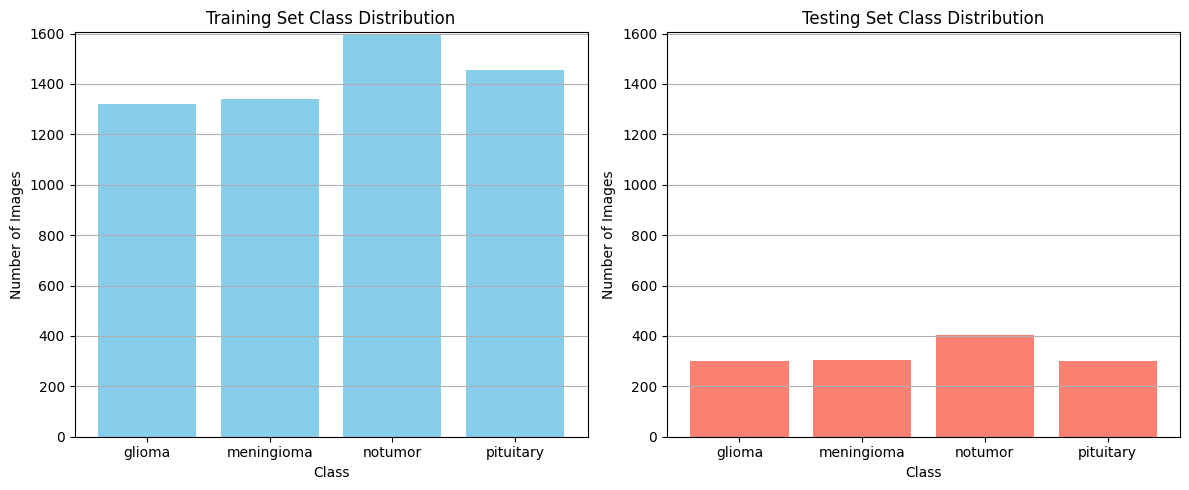

In [ ]:
# Plotting the class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].bar(class_counts["train"].keys(), class_counts["train"].values(), color='skyblue')
axes[0].set_title('Training Set Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Images')
axes[0].grid(axis='y')
axes[1].bar(class_counts["test"].keys(), class_counts["test"].values(), color='salmon')
axes[1].set_title('Testing Set Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Number of Images')
axes[1].grid(axis='y')
#Make the y-axis limits the same for better comparison
y_max = max(max(class_counts["train"].values()), max(class_counts["test"].values()))
axes[0].set_ylim(0, y_max + 10)
axes[1].set_ylim(0, y_max + 10)
plt.tight_layout()
plt.show()

In [ ]:
#Analysing binary class distribution for tumor vs no_tumor classification
binary_class_counts = {"train": {"notumor": 0, "tumor": 0}, "test": {"notumor": 0, "tumor": 0}}
for split, directory in [("train", train_dir), ("test", test_dir)]:
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            if class_name == "notumor":
                binary_class_counts[split]["notumor"] += num_images
            else:
                binary_class_counts[split]["tumor"] += num_images
print("Binary class distribution in training data:", binary_class_counts["train"])
print("Binary class distribution in testing data:", binary_class_counts["test"])

Binary class distribution in training data: {'notumor': 1595, 'tumor': 4117}
Binary class distribution in testing data: {'notumor': 405, 'tumor': 906}


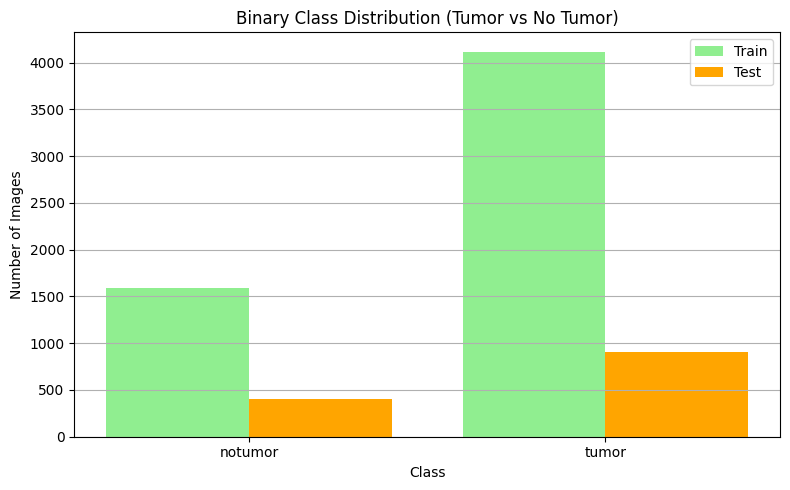

In [ ]:
# Plotting the binary class distribution in a grouped bar chart
labels = ['notumor', 'tumor']
train_counts = [binary_class_counts["train"]["notumor"], binary_class_counts["train"]["tumor"]]
test_counts = [binary_class_counts["test"]["notumor"], binary_class_counts["test"]["tumor"]]
x = range(len(labels))
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar([p - 0.2 for p in x], train_counts, width=0.4, label='Train', color='lightgreen')
ax.bar([p + 0.2 for p in x], test_counts, width=0.4, label='Test', color='orange')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title('Binary Class Distribution (Tumor vs No Tumor)')
ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.legend()
ax.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# Summary statistics
total_train_images = sum(class_counts["train"].values())
total_test_images = sum(class_counts["test"].values())
print(f"Total training images: {total_train_images}")
print(f"Total testing images: {total_test_images}")
num_classes = len(class_counts["train"])
print(f"Number of classes: {num_classes}")

Total training images: 5712
Total testing images: 1311
Number of classes: 4


Sample images from training set:


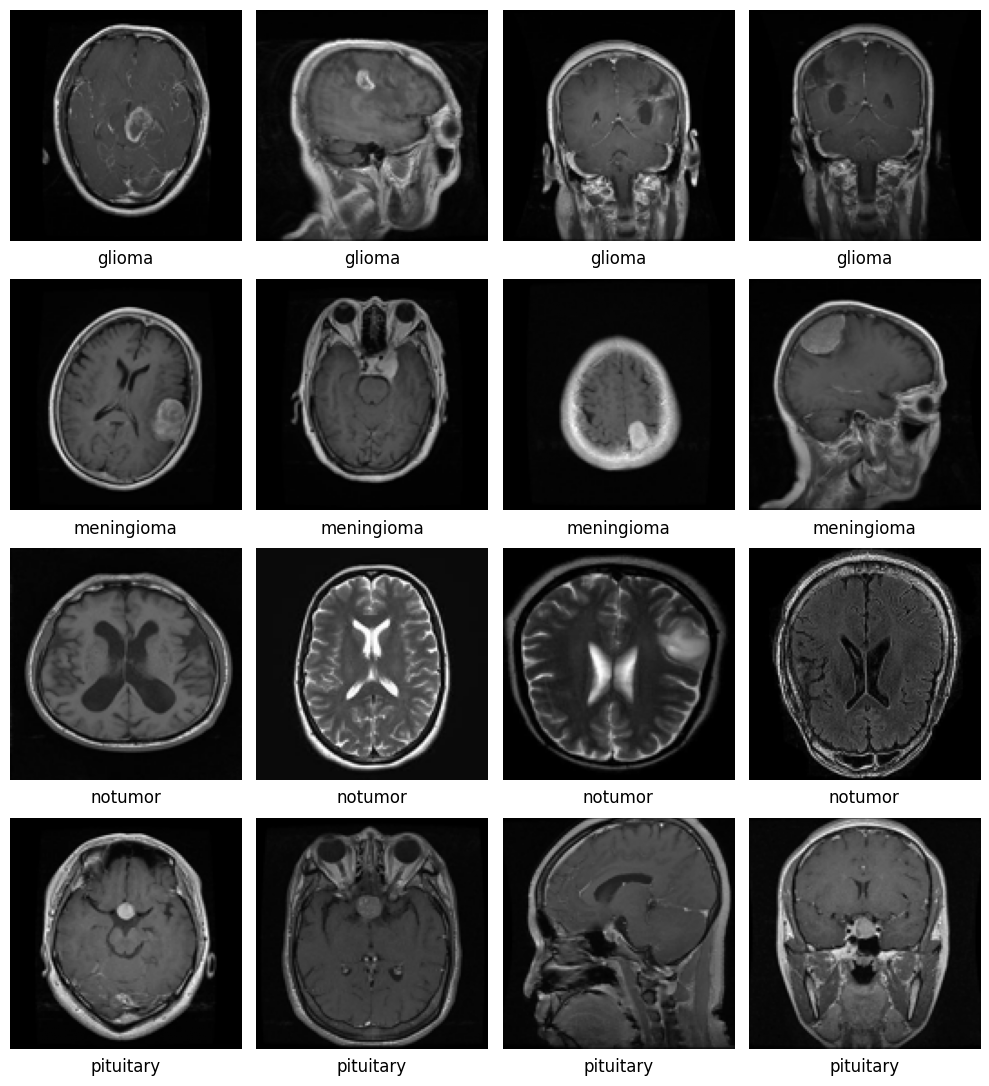

In [ ]:
def sample_images(dir, sample_per_class=4, figsize=(10,11), resize_to=(128, 128)):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    fig, axes = plt.subplots(len(classes), sample_per_class, figsize=figsize)
    if len(classes) == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one class
    for i, class_name in enumerate(classes):
        class_path = os.path.join(dir, class_name)
        images = os.listdir(class_path)
        chosen_images = random.sample(images, min(sample_per_class, len(images)))
        for j, img_name in enumerate(chosen_images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            if resize_to:
                img = img.resize(resize_to)
            axes[i][j].imshow(img, cmap='gray')
            axes[i][j].axis('off')
            axes[i][j].text(0.5, -0.1, class_name, size=12, ha="center", transform=axes[i][j].transAxes)
        for j in range(len(chosen_images), sample_per_class):
                axes[i][j].axis('off')
    plt.tight_layout()
    plt.show()
print("Sample images from training set:")
sample_images(train_dir)

## 02 - Model Training

### Imports

In [80]:
import os, csv, h5py
import numpy as np
from PIL import Image
from pathlib import Path
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from tqdm import tqdm
from config import KAGGLE_DATASET_PATH, BRATS_DATASET_PATH, MODEL_PARAMS

### Setting up Kaggle Brain MRI Dataloaders

In [81]:
class BinaryMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.labels = []
        self.classes = ['notumor', 'tumor']
        for cls in os.listdir(root_dir):
            cls_path = os.path.join(root_dir, cls)
            if not os.path.isdir(cls_path):
                continue
            for fn in os.listdir(cls_path):
                if fn.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append(os.path.join(cls_path, fn))
                    self.labels.append(0 if cls == 'notumor' else 1)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path = self.samples[idx]
        try:
            img = Image.open(path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {path}: {e}, providing a black image instead.")
            img = Image.new('RGB', (224, 224), (0,0,0))
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

In [82]:
# transforms
image_size = MODEL_PARAMS.get('image_size', 224)

# Training: mild augmentations for brain MRI
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.9, 1.0), ratio=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(p=0.5),         
    transforms.RandomVerticalFlip(p=0.2),           
    transforms.RandomAffine(
        degrees=15,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05),
        shear=0.0
    ),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),   
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5))], p=0.15),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.08), ratio=(0.3, 3.3), value='random'),
    transforms.Normalize(mean=[0.485,0.485,0.485], std=[0.229,0.229,0.229]),
])

val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.485,0.485], std=[0.229,0.229,0.229]),
])

In [83]:
# directories
base_dir = KAGGLE_DATASET_PATH
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Testing')

# datasets
train_dataset = BinaryMRIDataset(train_dir, transform=train_transform)
val_dataset = BinaryMRIDataset(test_dir, transform=val_transform)

print("Classes:", train_dataset.classes)
print("Train samples:", len(train_dataset), "Val samples:", len(val_dataset))

Classes: ['notumor', 'tumor']
Train samples: 5712 Val samples: 1311


In [84]:
# dataloaders
BATCH_SIZE = MODEL_PARAMS.get('batch_size', 32)
NUM_WORKERS = MODEL_PARAMS.get('num_workers', 4)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

### Setting Up BraTS Dataloader For External Validation

In [85]:
brats_dir = Path(BRATS_DATASET_PATH) / "content" / "data"
csv_path = "BraTS\BraTS_selected_slices.csv"

In [86]:
class BraTSDataset(Dataset):
    def __init__(self, root_dir, sample_csv, modality_index=2):
        self.root_dir = root_dir
        self.sample_csv = sample_csv
        self.modality_index = modality_index # Default to T1-contrast modality (index 2) to be consistent with Kaggle MRI Dataset
        self.samples = []

        with open(sample_csv, 'r') as f:
            reader = csv.reader(f)
            next(reader)  # skip header
            for row in reader:
                rel_path = row[0]
                full_path = os.path.join(root_dir, rel_path)
                if os.path.exists(full_path) and full_path.endswith(".h5"):
                    self.samples.append(full_path)

        self.normalize = transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
        self.resize = transforms.Resize((MODEL_PARAMS.get('image_size', 224), MODEL_PARAMS.get('image_size', 224)), antialias=True)

    @staticmethod
    def _minmax01(img_np):
        # Function to normalize image intensities to [0,1]
        lo, hi = np.min(img_np), np.max(img_np)
        img = np.clip(img_np, lo, hi)
        if hi > lo:
            img = (img - lo) / (hi - lo)
        else:
            print("Error: hi <= lo in minmax01 normalization for BraTS Dataset, returning zero image.")
            img = np.zeros_like(img_np, dtype=np.float32)
        return img.astype(np.float32)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        rel_path = self.samples[idx]
        with h5py.File(rel_path, 'r') as f:
            slice = f['image'][:][:, :, self.modality_index].astype(np.float32)  # (H, W)

        # Intensity normalize to [0,1]
        slice = self._minmax01(slice)
        # To torch tensor (C,H,W) and replicate to 3 channels for ImageNet backbone
        slice = torch.from_numpy(slice)[None, ...]               # (1,H,W)
        img = slice.repeat(3, 1, 1).contiguous()               # (3,H,W)
        # Apply same resizing + ImageNet normalization as Kaggle val
        img = self.resize(img)
        img = self.normalize(img)
        return img
            

Sample image shape from BraTS Dataset: torch.Size([3, 224, 224])
Number of samples in BraTS Dataset: 326


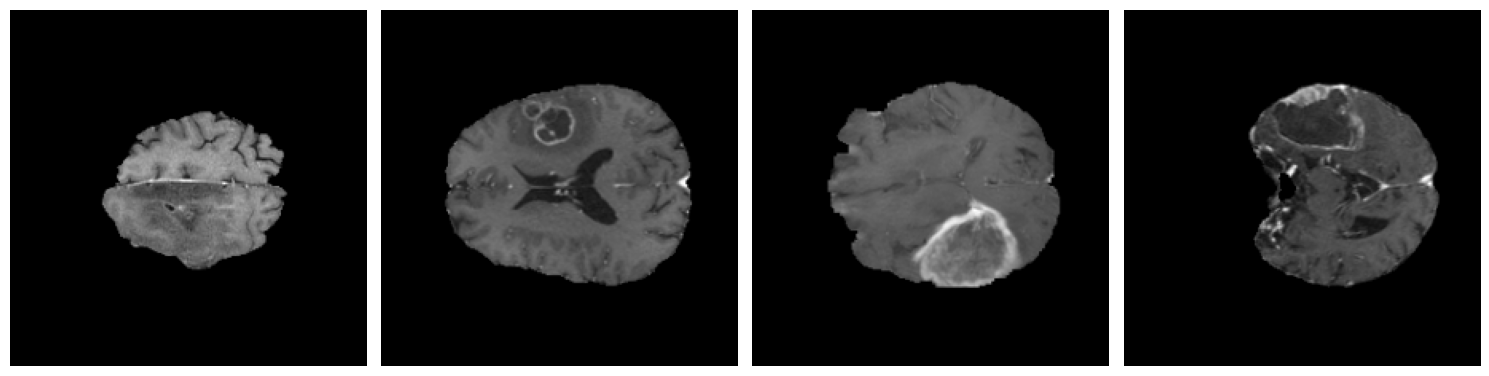

In [87]:
smaple_brats_ds = BraTSDataset(brats_dir, csv_path)

brats_len = len(smaple_brats_ds)
one_sample = smaple_brats_ds[0]
print("Sample image shape from BraTS Dataset:", one_sample.size())
print("Number of samples in BraTS Dataset:", brats_len)

#Plot some sample from BraTS dataset
num_samples = 4
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
for i in range(num_samples):
    sample = smaple_brats_ds[np.random.randint(0, brats_len)]
    #Plot just one channel since all 3 are identical
    img_np = sample[0].numpy()
    axes[i].imshow(img_np, cmap='gray')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# BraTS dataloader
brats_ds = BraTSDataset(brats_dir, csv_path)
brats_loader = DataLoader(brats_ds, batch_size=MODEL_PARAMS.get('batch_size', 16), shuffle=False)

### Training the Foundation Model

In [89]:
# model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = timm.create_model(MODEL_PARAMS.get('timm_model_name', 'resnet50'), pretrained=True, num_classes=2)
model = model.to(device)

# loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=MODEL_PARAMS.get('learning_rate', 1e-4), weight_decay=MODEL_PARAMS.get('weight_decay', 1e-5))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [90]:
# training loop
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(loader, desc='Train', leave=False)
    for inputs, labels in pbar:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        pbar.set_postfix(loss=running_loss/total, acc=100.*correct/total)
    return running_loss / total, 100.*correct/total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(loader, desc='Val', leave=False)
        for inputs, labels in pbar:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            pbar.set_postfix(loss=running_loss/total, acc=100.*correct/total)
    return running_loss / total, 100.*correct/total

In [ ]:
# BraTS evaluation function
def evaluate_brats_dataset(model, brats_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    label = 1 # BraTS samples all have tumors
    with torch.no_grad():
        pbar = tqdm(brats_loader, desc='BraTS Eval', leave=False)
        for inputs in pbar:
            inputs = inputs.to(device, non_blocking=True)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            loss = criterion(outputs, torch.full((inputs.size(0),), label, dtype=torch.long, device=device))
            running_loss += loss.item() * inputs.size(0)
            correct += (preds == label).sum().item()
            total += inputs.size(0)
            pbar.set_postfix(running_loss = running_loss/total, acc = 100.*correct/total)
    return running_loss / total, 100.*correct/total

In [92]:
# run Kaggle training with BraTS evaluation
epochs = MODEL_PARAMS.get('num_epochs', 25)
best_val_acc = 0.0
save_best = MODEL_PARAMS.get('save_best', False)
model_name = MODEL_PARAMS.get('save_name', 'best_model.pth')
save_path = Path(MODEL_PARAMS.get('save_path', 'runs')) / model_name

for epoch in range(1, epochs+1):
    print(f"Epoch {epoch}/{epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    brats_loss, brats_acc = evaluate_brats_dataset(model, brats_loader, criterion, device)
    scheduler.step()
    
    print(f"  Train loss: {train_loss:.4f}  acc: {train_acc:.2f}%")
    print(f"  Val   loss: {val_loss:.4f}  acc: {val_acc:.2f}%")
    print(f"  BraTS loss: {brats_loss:.4f}  acc: {brats_acc:.2f}%")

    if save_best and val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'classes': train_dataset.classes
        }, save_path)
        print(f"  Saved best model to {save_path} (val_acc={val_acc:.2f}%)")

print(f"Training finished. Best Val acc: {best_val_acc:.2f}%")

Epoch 1/25


  Train loss: 0.2367  acc: 91.91%
  Val   loss: 0.2835  acc: 88.56%
  BraTS loss: 0.0002  acc: 100.00%
  Saved best model to runs\experiment_1\best_model.pth (val_acc=88.56%)
Epoch 2/25


  Train loss: 0.1374  acc: 95.47%
  Val   loss: 0.2917  acc: 87.72%
  BraTS loss: 1.2705  acc: 37.12%
Epoch 3/25


  Train loss: 0.1139  acc: 96.32%
  Val   loss: 0.2009  acc: 92.91%
  BraTS loss: 0.5085  acc: 79.45%
  Saved best model to runs\experiment_1\best_model.pth (val_acc=92.91%)
Epoch 4/25


  Train loss: 0.1145  acc: 95.99%
  Val   loss: 2.9358  acc: 41.34%
  BraTS loss: 9.3822  acc: 0.00%
Epoch 5/25


  Train loss: 0.0911  acc: 96.92%
  Val   loss: 0.1829  acc: 91.76%
  BraTS loss: 0.7086  acc: 52.15%
Epoch 6/25


  Train loss: 0.0777  acc: 97.36%
  Val   loss: 0.0826  acc: 96.41%
  BraTS loss: 0.0053  acc: 100.00%
  Saved best model to runs\experiment_1\best_model.pth (val_acc=96.41%)
Epoch 7/25


  Train loss: 0.0679  acc: 97.65%
  Val   loss: 0.1053  acc: 96.03%
  BraTS loss: 0.2020  acc: 95.40%
Epoch 8/25


  Train loss: 0.0573  acc: 97.97%
  Val   loss: 0.0898  acc: 97.03%
  BraTS loss: 0.0316  acc: 100.00%
  Saved best model to runs\experiment_1\best_model.pth (val_acc=97.03%)
Epoch 9/25


  Train loss: 0.0591  acc: 97.99%
  Val   loss: 0.0873  acc: 96.72%
  BraTS loss: 0.1499  acc: 99.08%
Epoch 10/25


  Train loss: 0.0632  acc: 97.78%
  Val   loss: 0.1127  acc: 95.80%
  BraTS loss: 0.1518  acc: 97.24%
Epoch 11/25


  Train loss: 0.0443  acc: 98.60%
  Val   loss: 0.0627  acc: 97.94%
  BraTS loss: 0.0091  acc: 100.00%
  Saved best model to runs\experiment_1\best_model.pth (val_acc=97.94%)
Epoch 12/25


  Train loss: 0.0375  acc: 98.67%
  Val   loss: 0.0754  acc: 97.10%
  BraTS loss: 0.0352  acc: 99.69%
Epoch 13/25


  Train loss: 0.0341  acc: 98.67%
  Val   loss: 0.0630  acc: 98.02%
  BraTS loss: 0.0707  acc: 97.55%
  Saved best model to runs\experiment_1\best_model.pth (val_acc=98.02%)
Epoch 14/25


  Train loss: 0.0335  acc: 98.84%
  Val   loss: 0.0432  acc: 98.70%
  BraTS loss: 0.1853  acc: 93.25%
  Saved best model to runs\experiment_1\best_model.pth (val_acc=98.70%)
Epoch 15/25


  Train loss: 0.0397  acc: 98.81%
  Val   loss: 0.0502  acc: 98.47%
  BraTS loss: 0.0830  acc: 98.47%
Epoch 16/25


  Train loss: 0.0287  acc: 99.07%
  Val   loss: 0.0346  acc: 99.01%
  BraTS loss: 0.0193  acc: 100.00%
  Saved best model to runs\experiment_1\best_model.pth (val_acc=99.01%)
Epoch 17/25


  Train loss: 0.0258  acc: 99.05%
  Val   loss: 0.0283  acc: 99.24%
  BraTS loss: 0.0173  acc: 100.00%
  Saved best model to runs\experiment_1\best_model.pth (val_acc=99.24%)
Epoch 18/25


  Train loss: 0.0242  acc: 99.19%
  Val   loss: 0.0376  acc: 98.55%
  BraTS loss: 0.0050  acc: 99.69%
Epoch 19/25


  Train loss: 0.0268  acc: 99.12%
  Val   loss: 0.0446  acc: 98.40%
  BraTS loss: 0.0137  acc: 99.69%
Epoch 20/25


  Train loss: 0.0178  acc: 99.40%
  Val   loss: 0.0295  acc: 99.01%
  BraTS loss: 0.0047  acc: 99.69%
Epoch 21/25


  Train loss: 0.0199  acc: 99.40%
  Val   loss: 0.0219  acc: 99.47%
  BraTS loss: 0.0050  acc: 99.69%
  Saved best model to runs\experiment_1\best_model.pth (val_acc=99.47%)
Epoch 22/25


  Train loss: 0.0157  acc: 99.49%
  Val   loss: 0.0256  acc: 99.39%
  BraTS loss: 0.0099  acc: 99.39%
Epoch 23/25


  Train loss: 0.0148  acc: 99.61%
  Val   loss: 0.0281  acc: 99.24%
  BraTS loss: 0.0105  acc: 99.08%
Epoch 24/25


  Train loss: 0.0201  acc: 99.47%
  Val   loss: 0.0206  acc: 99.47%
  BraTS loss: 0.0026  acc: 100.00%
Epoch 25/25


  Train loss: 0.0137  acc: 99.53%
  Val   loss: 0.0274  acc: 99.24%
  BraTS loss: 0.0184  acc: 99.08%
Training finished. Best Val acc: 99.47%


In [94]:
# final evaluation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

load_path = Path(MODEL_PARAMS.get('save_path', 'runs')) / MODEL_PARAMS.get('save_name', 'best_model.pth')
model_metadata = torch.load(load_path)

model = timm.create_model(MODEL_PARAMS.get("timm_model_name", "resnet50"), pretrained=False, num_classes=2)
model.load_state_dict(model_metadata['model_state_dict'])
model = model.to(device)
criterion = nn.CrossEntropyLoss()

val_loss, val_acc = validate(model, val_loader, criterion, device)
brats_loss, brats_acc = evaluate_brats_dataset(model, brats_loader, criterion, device)
print(f"Final Validation loss: {val_loss:.4f}  acc: {val_acc:.2f}%")
print(f"Final BraTS loss: {brats_loss:.4f}  acc: {brats_acc:.2f}%")

Final Validation loss: 0.0219  acc: 99.47%
Final BraTS loss: 0.0050  acc: 99.69%
